In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
import numpy as np
import difflib
from tqdm import tqdm
import matplotlib.ticker as ticker
import os

source_dir = '/data/commonsense-data-selection/visual_detail/for_paper/prediction'

models = ['BLIP-2 (FlanT5$_{\mathrm{XXL}}$)',
 'InstructBLIP (Vicuna-13B)',
 'LLaVA-1.5 (Vicuna-13B)',
 'Fuyu-8B',
 'Qwen-VL-Chat']

models_to_file = {'BLIP-2 (FlanT5$_{\mathrm{XXL}}$)': 'blip2-flan-t5-xxl',
'InstructBLIP (Vicuna-13B)': 'instructblip-vicuna-13b',
'LLaVA-1.5 (Vicuna-13B)': 'llava-1.5-13b-hf',
'Fuyu-8B': 'fuyu-8b',
'Qwen-VL-Chat': 'Qwen-VL-Chat'}


plt.rcParams.update({'font.size': 16})

if not os.path.exists('./plots'):
    os.makedirs('./plots')

def string_similarity(str1, str2):
    return difflib.SequenceMatcher(None, str1, str2).ratio()

def get_group_accuracy(datas):
    result = {}
    for img_name, prediction in datas.items():
        prediction = prediction.split('\n')[0]
        img_content = img_name.split('.png')[0]
        gt, group = img_content.split('_')
        group = group.split('-')[0]
        score = string_similarity(prediction, gt)
        if group not in result:
            result[group] = [score]
        else:
            result[group].append(score)
    for group, scores in result.items():
        result[group] = 100*np.mean(scores)
    result = {k: v for k, v in sorted(result.items(), key=lambda item: float(item[0]))}
    return result

# quality

100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

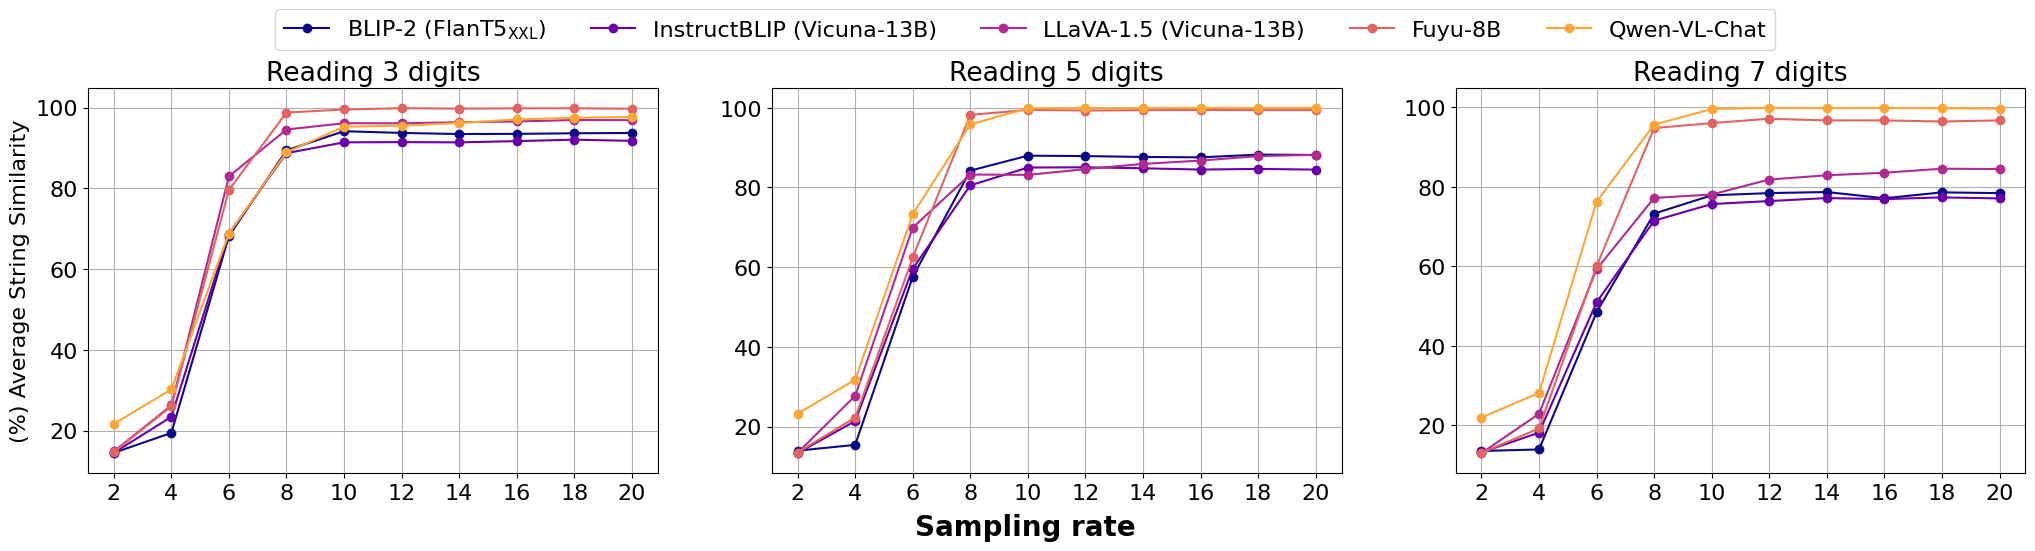

In [2]:
task_name = 'quality'

task_variations = ['3', '5', '7']

result = {}
for v in tqdm(task_variations):
    result[v] = {}
    for model in models:
        with open(f'{source_dir}/{models_to_file[model]}_{task_name}_{v}.json', 'r') as f:
            data = json.load(f)
        result[v][model] = get_group_accuracy(data)

fig, ax = plt.subplots(1, 3, figsize=(25, 5), sharex=True)

color_map = plt.get_cmap('plasma')

for i, (v, r) in enumerate(result.items()):
    ax[i].set_title(f'Reading {v} digits')
    ax[i].grid()
    for model, acc in r.items():
        ax[i].plot(acc.keys(), acc.values(), label=model, marker='o', color=color_map(models.index(model)/len(models)))
    y_min = min([min(acc.values()) for acc in r.values()])
    y_max = max([max(acc.values()) for acc in r.values()])
    ax[i].set_ylim(y_min-5, y_max+5)
fig.legend(loc='upper center', ncol=5, labels=models, bbox_to_anchor=(0.5, 1.06))
plt.suptitle('Sampling rate', y=0.03, ha='center', fontsize=20, weight='bold')
ax[0].set_ylabel('(%) Average String Similarity')
plt.savefig(f'./plots/{task_name}.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# size

100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


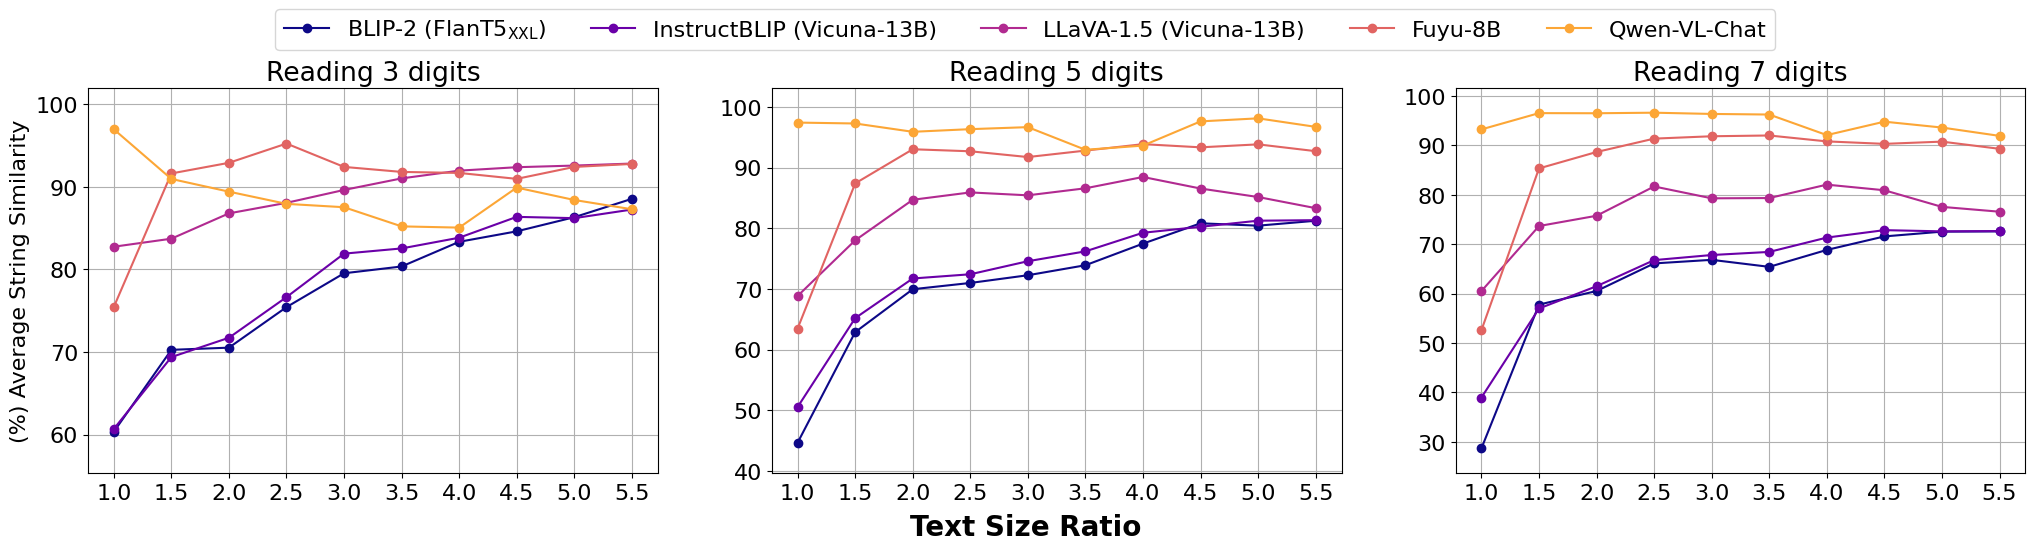

In [3]:
task_name = 'size'

task_variations = ['3', '5', '7']

result = {}
for v in tqdm(task_variations):
    result[v] = {}
    for model in models:
        if model == 'Qwen-VL-Chat' and v == '7':
            this_v = '20'
        else:
            this_v = v
        with open(f'{source_dir}/{models_to_file[model]}_{task_name}_{this_v}.json', 'r') as f:
            data = json.load(f)
        result[v][model] = get_group_accuracy(data)

fig, ax = plt.subplots(1, 3, figsize=(25, 5), sharex=True)

color_map = plt.get_cmap('plasma')

for i, (v, r) in enumerate(result.items()):
    ax[i].set_title(f'Reading {v} digits')
    ax[i].grid()
    for model, acc in r.items():
        ax[i].plot(acc.keys(), acc.values(), label=model, marker='o', color=color_map(models.index(model)/len(models)))
    y_min = min([min(acc.values()) for acc in r.values()])
    y_max = max([max(acc.values()) for acc in r.values()])
    ax[i].set_ylim(y_min-5, y_max+5)

ax[0].set_ylabel('(%) Average String Similarity')
fig.legend(loc='upper center', ncol=5, labels=models, bbox_to_anchor=(0.5, 1.06))
plt.suptitle('Text Size Ratio', y=0.03, ha='center', fontsize=20, weight='bold')
plt.savefig(f'./plots/{task_name}.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# position

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


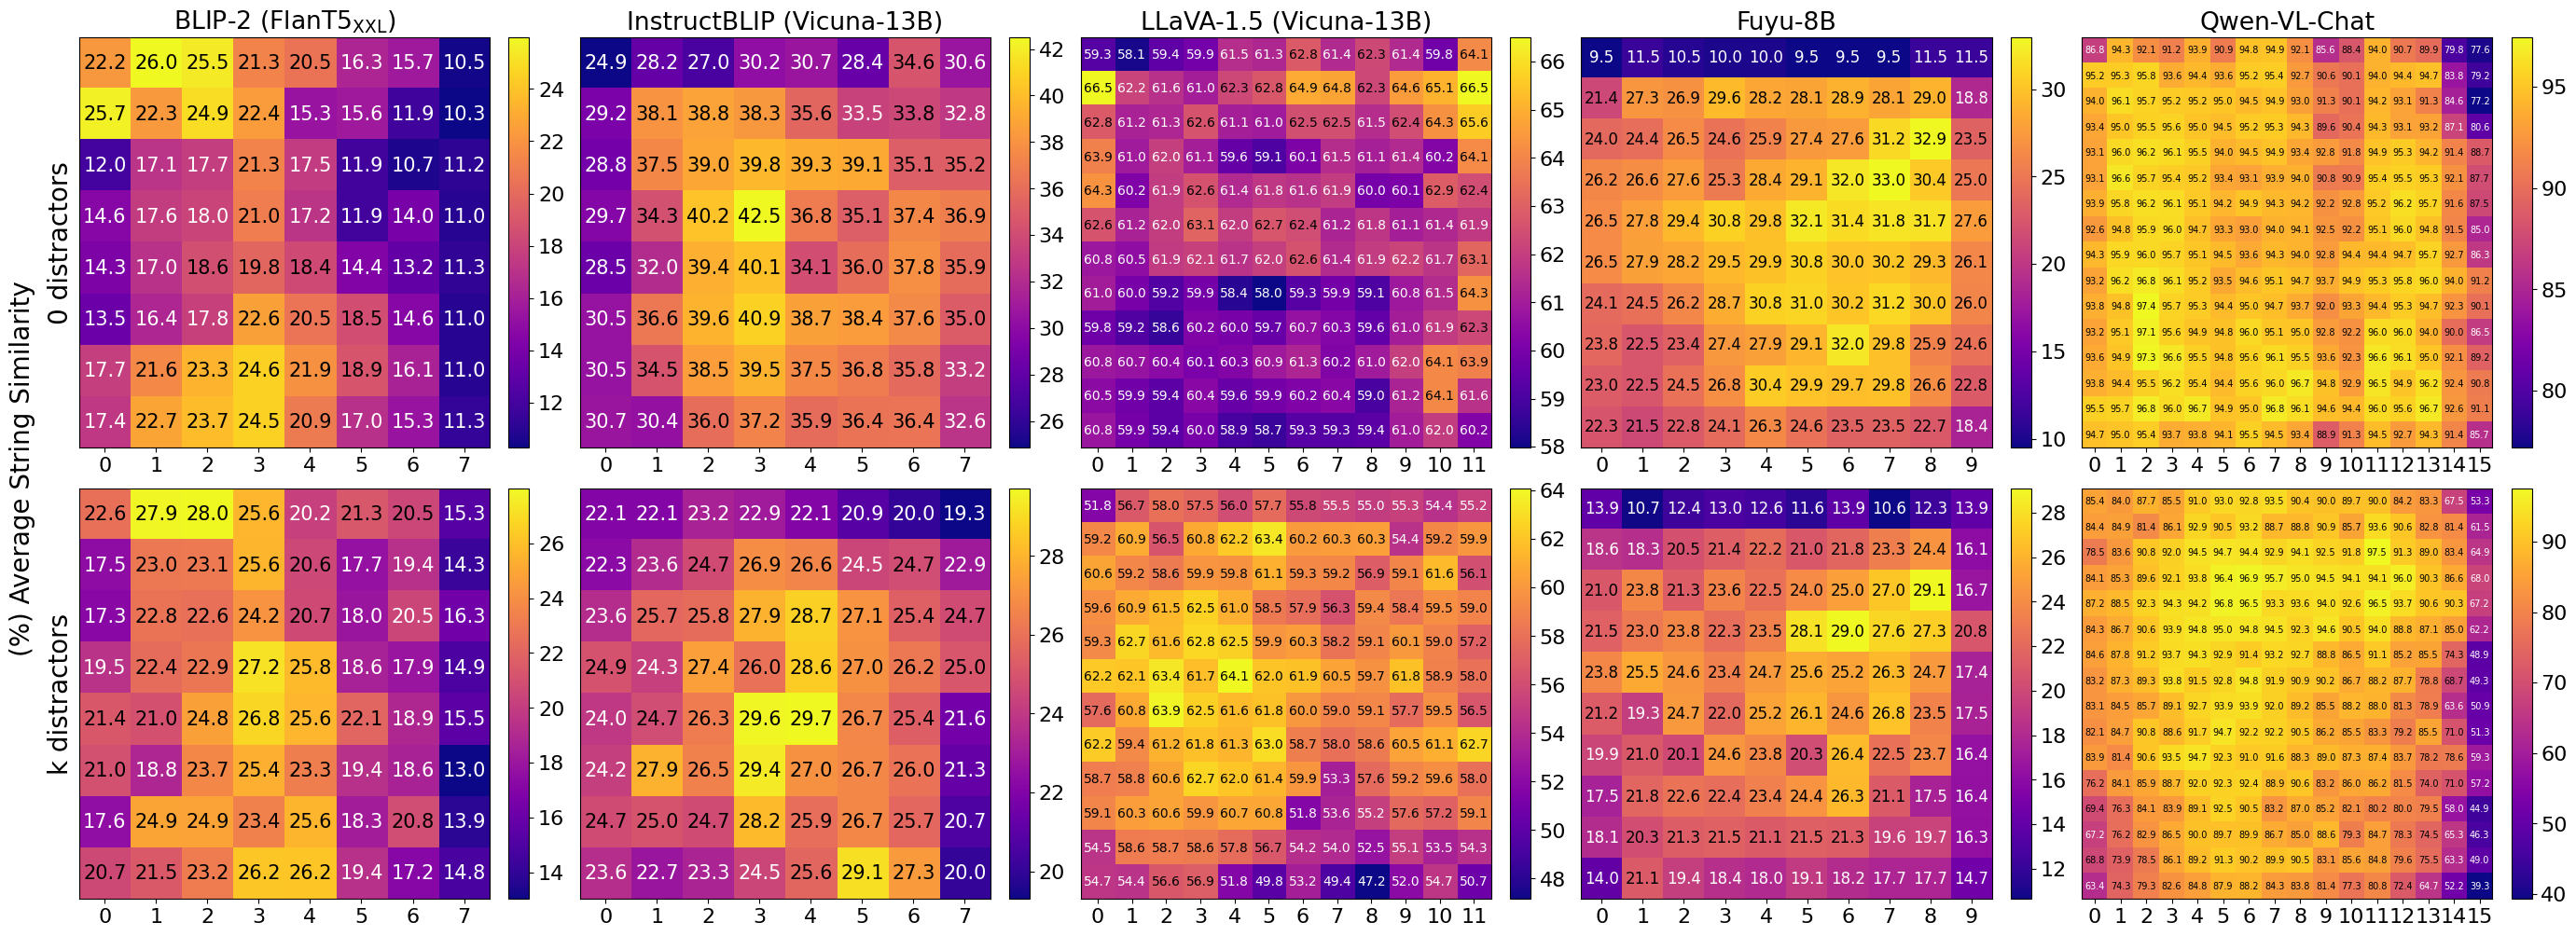

In [45]:
task_name = 'position'

task_variations = ['0', '1']

model_to_patch = {'blip2-flan-t5-xxl': 8, 
                   'fuyu-8b': 10, 
                   'instructblip-vicuna-13b': 8, 
                   'llava-1.5-13b-hf': 12,
                   'Qwen-VL-Chat': 16}

result = {}
for v in tqdm(task_variations):
    result[v] = {}
    for model in models:
        if model == 'Qwen-VL-Chat' and v == '1':
            this_v = '9'
        else:
            this_v = v
        with open(f'{source_dir}/{models_to_file[model]}_{task_name}_{this_v}.json', 'r') as f:
            data = json.load(f)
        result[v][model] = get_group_accuracy(data)

base_colormap = matplotlib.colormaps['plasma']
start = 0
stop = 1
new_colors = base_colormap(np.linspace(start, stop, 256))
new_colormap = mcolors.LinearSegmentedColormap.from_list('new_colormap', new_colors)


fig, axs = plt.subplots(2, 5, figsize=(29, 10))

hm_data = {}

for m, v in enumerate(task_variations):
    for n, model in enumerate(models):
        num_patches = model_to_patch[models_to_file[model]]
        font_size = int(120/num_patches)
        hm_data = np.zeros((num_patches, num_patches))
        for key, value in result[v][model].items():
            cpos = int(key)
            hm_data[cpos // num_patches][cpos % num_patches] = value
        ax = axs[m, n]
        im = ax.imshow(hm_data, cmap=new_colormap)
        cbar = ax.figure.colorbar(im, ax=ax, pad=0.03)
        locator = ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10])
        cbar.locator = locator
        cbar.update_ticks()
        ax.set_xticks(np.arange(num_patches))
        ax.set_yticks([])
        if m == 0:
            ax.set_title(model)
        if n == 0:
            k = 'k' if m == 1 else '0'
            ax.set_ylabel(f'{k} distractors', fontsize=20)
        half_position = (np.max(hm_data) + np.min(hm_data)) / 2
        for i in range(num_patches):
            for j in range(num_patches):
                if hm_data[i, j] < half_position:
                    text = ax.text(j, i, f'{hm_data[i, j]:.1f}', ha="center", va="center", color="w", fontsize=font_size)
                else:
                    text = ax.text(j, i, f'{hm_data[i, j]:.1f}', ha="center", va="center", color="black", fontsize=font_size)
# set a global y title
fig.text(0.032, 0.5, '(%) Average String Similarity', va='center', fontsize=20, rotation=90)

fig.tight_layout()
plt.subplots_adjust(wspace=-0.2, hspace=0.1)

plt.savefig(f'./plots/{task_name}.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# hcut

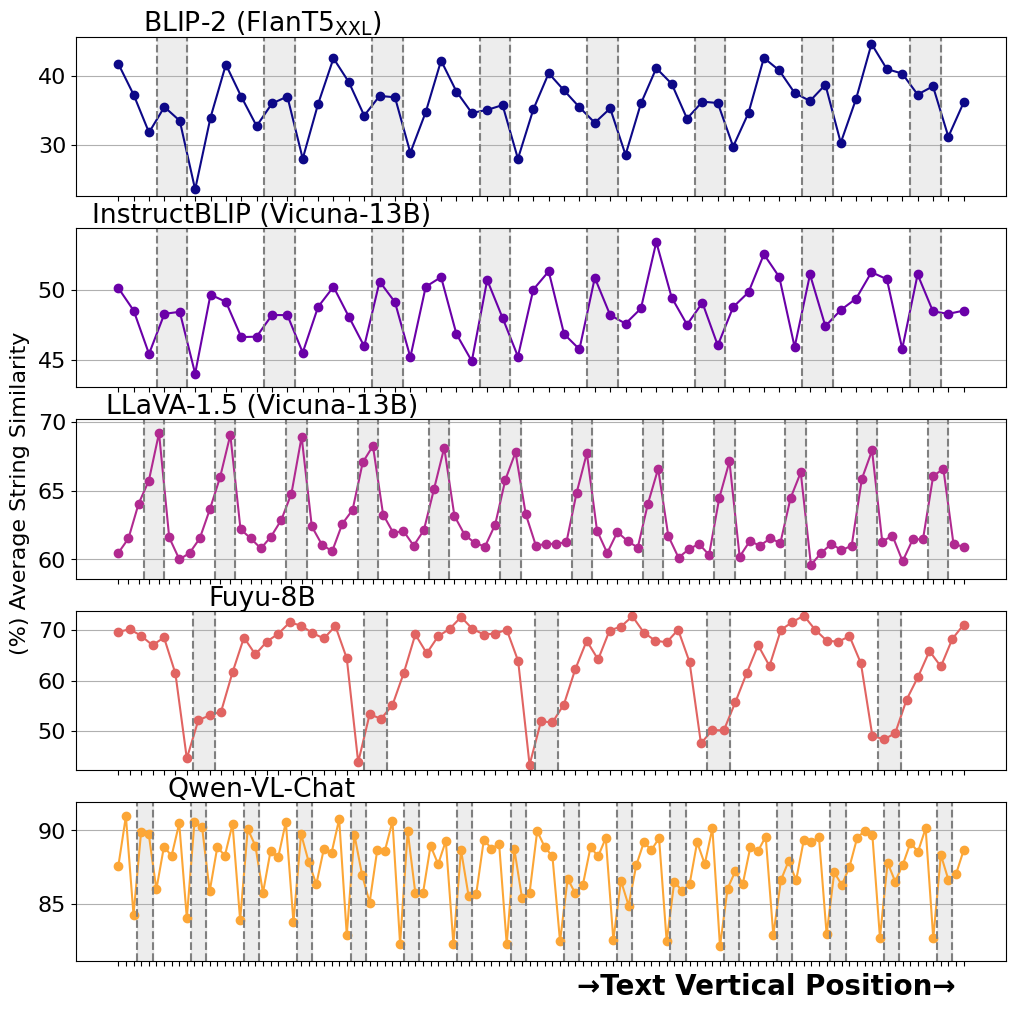

In [3]:
task_name = 'hcut'

task_variations = ['3', '6']

model_to_patch_size = {'blip2-flan-t5-xxl': 14, 
                   'fuyu-8b': 30, 
                   'instructblip-vicuna-13b': 14, 
                   'llava-1.5-13b-hf': 14,
                   'Qwen-VL-Chat': 14}


model_to_patch_num = {'blip2-flan-t5-xxl': 16, 
                   'fuyu-8b': 10, 
                   'instructblip-vicuna-13b': 16, 
                   'llava-1.5-13b-hf': 24,
                   'Qwen-VL-Chat': 32}

result = {}
for model in models:
    if models_to_file[model] == 'fuyu-8b':
        v = '6'
    else:
        v = '3'
    with open(f'{source_dir}/{models_to_file[model]}_{task_name}_{v}.json', 'r') as f:
        data = json.load(f)
    result[model] = get_group_accuracy(data)

fig, ax = plt.subplots(len(models), 1, figsize=(12, 12))

color_map = plt.get_cmap('plasma')

for j, (model, acc) in enumerate(result.items()):
    ax[j].set_title(f'{model}', x=0.2, y=0.98)
    patch_size = model_to_patch_size[models_to_file[model]]
    patch_num = model_to_patch_num[models_to_file[model]]
    quater_num = patch_num//4
    end_num = 3*patch_num//4
    model_range = ((quater_num)*patch_size//2, (end_num)*patch_size//2)
    ax[j].yaxis.grid(True)
    ax[j].plot(list(acc.keys())[model_range[0]:model_range[1]], list(acc.values())[model_range[0]:model_range[1]], label=model, marker='o', color=color_map(models.index(model)/len(models)))
    ax[j].set_xticklabels([])
    span = 6.5 if models_to_file[model] == 'fuyu-8b' else 2.5
    for k in range(patch_num//2):
        ax[j].axvspan(patch_size*k//2+span, patch_size*k//2-span + patch_size//2, alpha=0.4, color='lightgrey')
        ax[j].axvline(x=patch_size*k//2 - span + patch_size//2, color='grey', linestyle='--')
        ax[j].axvline(x=patch_size*k//2 + span, color='grey', linestyle='--')
    y_min = min(list(acc.values())[model_range[0]:model_range[1]])
    y_max = max(list(acc.values())[model_range[0]:model_range[1]])
    ax[j].set_ylim(y_min-1, y_max+1)

fig.text(0.07, 0.5, '(%) Average String Similarity', va='center', rotation='vertical')

plt.suptitle('\u2192Text Vertical Position\u2192', y=0.1, ha='center', fontsize=20, x=0.7, weight='bold')

plt.savefig(f'./plots/{task_name}.pdf', bbox_inches='tight', pad_inches=0.1)

plt.show()

# vcut

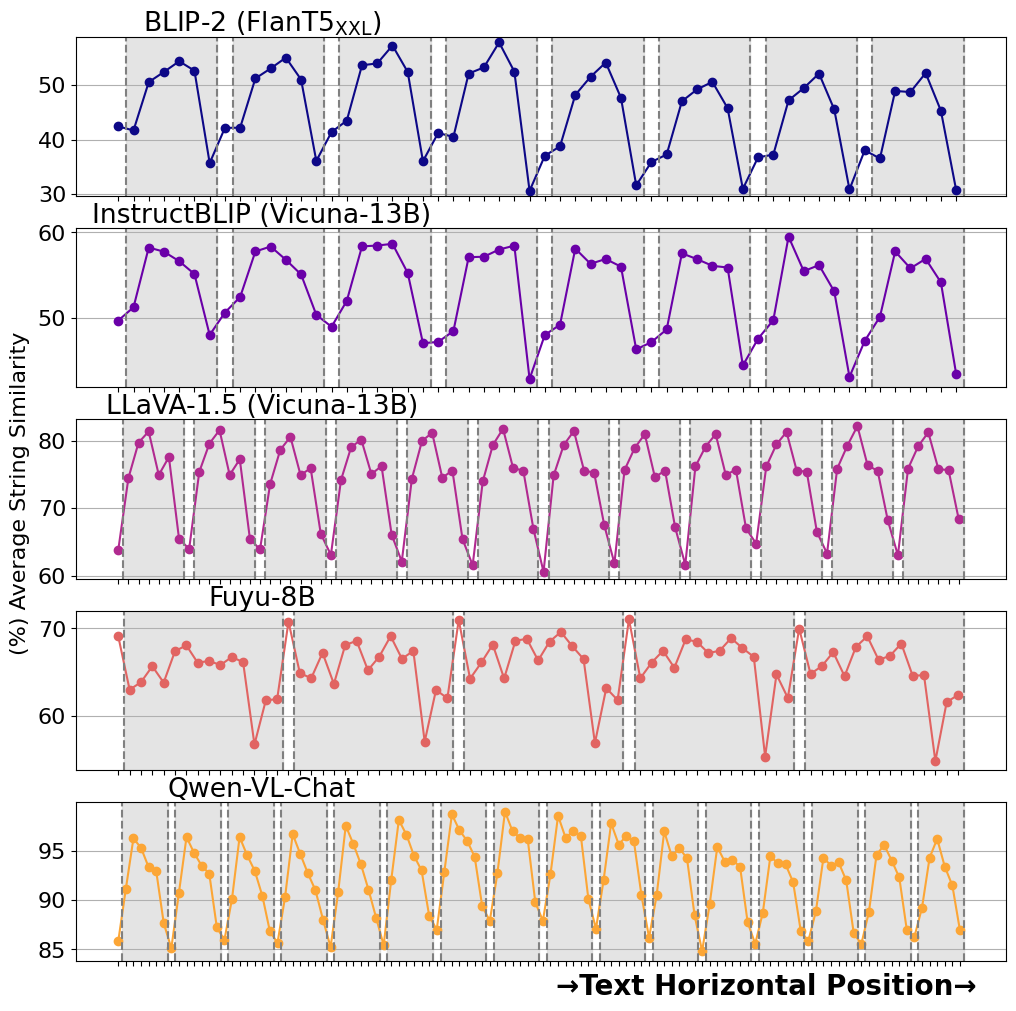

In [44]:
task_name = 'vcut'

task_variations = ['3', '6']

model_to_patch_size = {'blip2-flan-t5-xxl': 14, 
                   'fuyu-8b': 30, 
                   'instructblip-vicuna-13b': 14, 
                   'llava-1.5-13b-hf': 14,
                   'Qwen-VL-Chat': 14}


model_to_patch_num = {'blip2-flan-t5-xxl': 16, 
                   'fuyu-8b': 10, 
                   'instructblip-vicuna-13b': 16, 
                   'llava-1.5-13b-hf': 24,
                   'Qwen-VL-Chat': 32}


result = {}
for model in models:
    if models_to_file[model] == 'fuyu-8b':
        v = '6'
    else:
        v = '3'
    with open(f'{source_dir}/{models_to_file[model]}_{task_name}_{v}.json', 'r') as f:
        data = json.load(f)
    result[model] = get_group_accuracy(data)

fig, ax = plt.subplots(len(models), 1, figsize=(12, 12))

color_map = plt.get_cmap('plasma')

for j, (model, acc) in enumerate(result.items()):

    ax[j].set_title(f'{model}', x=0.2, y=0.98)
    patch_size = model_to_patch_size[models_to_file[model]]
    patch_num = model_to_patch_num[models_to_file[model]]
    quater_num = patch_num//4
    end_num = 3*patch_num//4
    model_range = ((quater_num)*patch_size//2, (end_num)*patch_size//2)
    model_range = (0,-1)
    ax[j].yaxis.grid(True)
    ax[j].plot(list(acc.keys())[model_range[0]:model_range[1]], list(acc.values())[model_range[0]:model_range[1]], label=model, marker='o', color=color_map(models.index(model)/len(models)))
    ax[j].set_xticklabels([])
    span = 1.5 if model == 'fuyu-8b' else 0.5
    for k in range(patch_num//2):
        ax[j].axvspan(patch_size*k//2+span, patch_size*k//2-span + patch_size//2, alpha=0.6, color='lightgrey')
        ax[j].axvline(x=patch_size*k//2 - span + patch_size//2, color='grey', linestyle='--')
        ax[j].axvline(x=patch_size*k//2 + span, color='grey', linestyle='--')
    y_min = min(list(acc.values())[model_range[0]:model_range[1]])
    y_max = max(list(acc.values())[model_range[0]:model_range[1]])
    ax[j].set_ylim(y_min-1, y_max+1)
# give the whole figure a y label
fig.text(0.07, 0.5, '(%) Average String Similarity', va='center', rotation='vertical')
plt.suptitle('\u2192Text Horizontal Position\u2192', y=0.1, ha='center',fontsize=20, x=0.7, weight='bold')
plt.savefig(f'./plots/{task_name}.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# distractor

100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


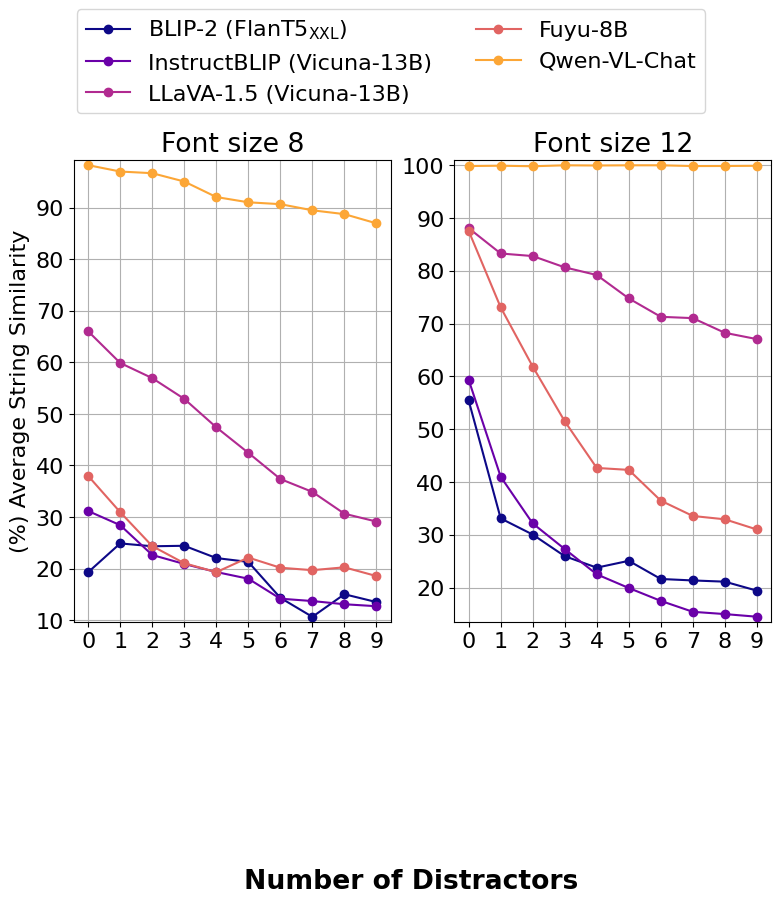

In [5]:
task_name = 'distract'

task_variations = ['8', '12']

source_dir

result = {}
for v in tqdm(task_variations):
    result[v] = {}
    for model in models:
        with open(f'{source_dir}/{models_to_file[model]}_{task_name}_{v}.json', 'r') as f:
            data = json.load(f)
        result[v][model] = get_group_accuracy(data)

fig, axs = plt.subplots(1, 2, figsize=(9, 6))

color_map = plt.get_cmap('plasma')

for i, (v, r) in enumerate(result.items()):
    ax = axs[i]
    ax.set_title(f'Font size {v}')
    # ax[i].set_xlabel('Text Size')
    # ax.set_ylabel('Average String Similarity')
    ax.grid()
    for model, acc in r.items():
        ax.plot(acc.keys(), acc.values(), label=model, marker='o', color=color_map(models.index(model)/len(models)))
    y_min = min([min(acc.values()) for acc in r.values()])
    y_max = max([max(acc.values()) for acc in r.values()])
    ax.set_ylim(y_min-1, y_max+1)
axs[0].set_ylabel('(%) Average String Similarity')
axs[0].legend(loc='upper center', ncol=2, labels=models, bbox_to_anchor=(1, 1.35))
plt.suptitle('Number of Distractors', y=-0.3, ha='center', weight='bold')
plt.savefig(f'./plots/{task_name}.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# hcut compelete

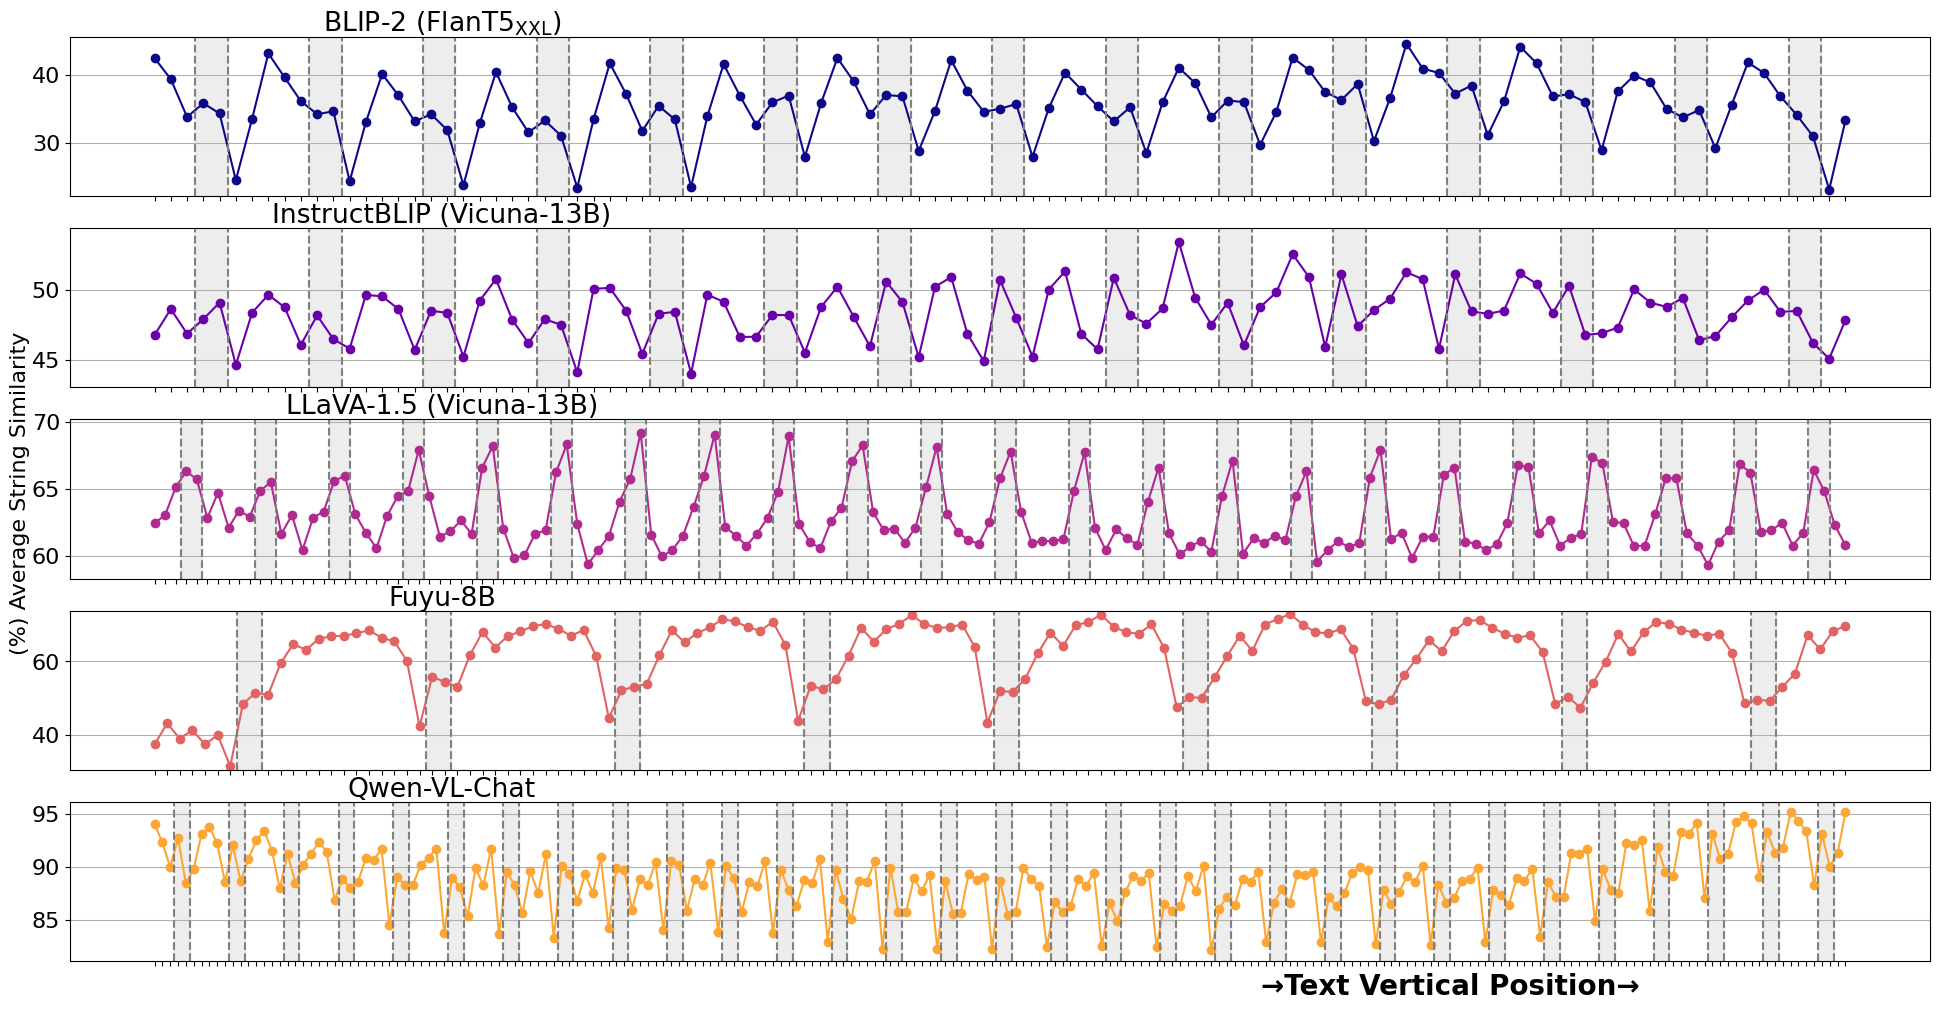

In [2]:
task_name = 'hcut'

task_variations = ['3', '6']

model_to_patch_size = {'blip2-flan-t5-xxl': 14, 
                   'fuyu-8b': 30, 
                   'instructblip-vicuna-13b': 14, 
                   'llava-1.5-13b-hf': 14,
                   'Qwen-VL-Chat': 14}


model_to_patch_num = {'blip2-flan-t5-xxl': 16, 
                   'fuyu-8b': 10, 
                   'instructblip-vicuna-13b': 16, 
                   'llava-1.5-13b-hf': 24,
                   'Qwen-VL-Chat': 32}

result = {}
for model in models:
    if models_to_file[model] == 'fuyu-8b':
        v = '6'
    else:
        v = '3'
    with open(f'{source_dir}/{models_to_file[model]}_{task_name}_{v}.json', 'r') as f:
        data = json.load(f)
    result[model] = get_group_accuracy(data)

fig, ax = plt.subplots(len(models), 1, figsize=(24, 12))

color_map = plt.get_cmap('plasma')

for j, (model, acc) in enumerate(result.items()):
    ax[j].set_title(f'{model}', x=0.2, y=0.98)
    patch_size = model_to_patch_size[models_to_file[model]]
    patch_num = model_to_patch_num[models_to_file[model]]
    ax[j].yaxis.grid(True)
    ax[j].plot(list(acc.keys()), list(acc.values()), label=model, marker='o', color=color_map(models.index(model)/len(models)))
    ax[j].set_xticklabels([])
    span = 6.5 if models_to_file[model] == 'fuyu-8b' else 2.5
    for k in range(patch_num-1):
        ax[j].axvspan(patch_size*k//2+span, patch_size*k//2-span + patch_size//2, alpha=0.4, color='lightgrey')
        ax[j].axvline(x=patch_size*k//2 - span + patch_size//2, color='grey', linestyle='--')
        ax[j].axvline(x=patch_size*k//2 + span, color='grey', linestyle='--')
    y_min = min(list(acc.values()))
    y_max = max(list(acc.values()))
    ax[j].set_ylim(y_min-1, y_max+1)

# give the whole figure a y label
fig.text(0.1, 0.5, '(%) Average String Similarity', va='center', rotation='vertical')
# bold the title
plt.suptitle('\u2192Text Vertical Position\u2192', y=0.1, ha='center', fontsize=20, x=0.7, weight='bold')
plt.savefig(f'./plots/compelete_{task_name}.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# vcut compelete

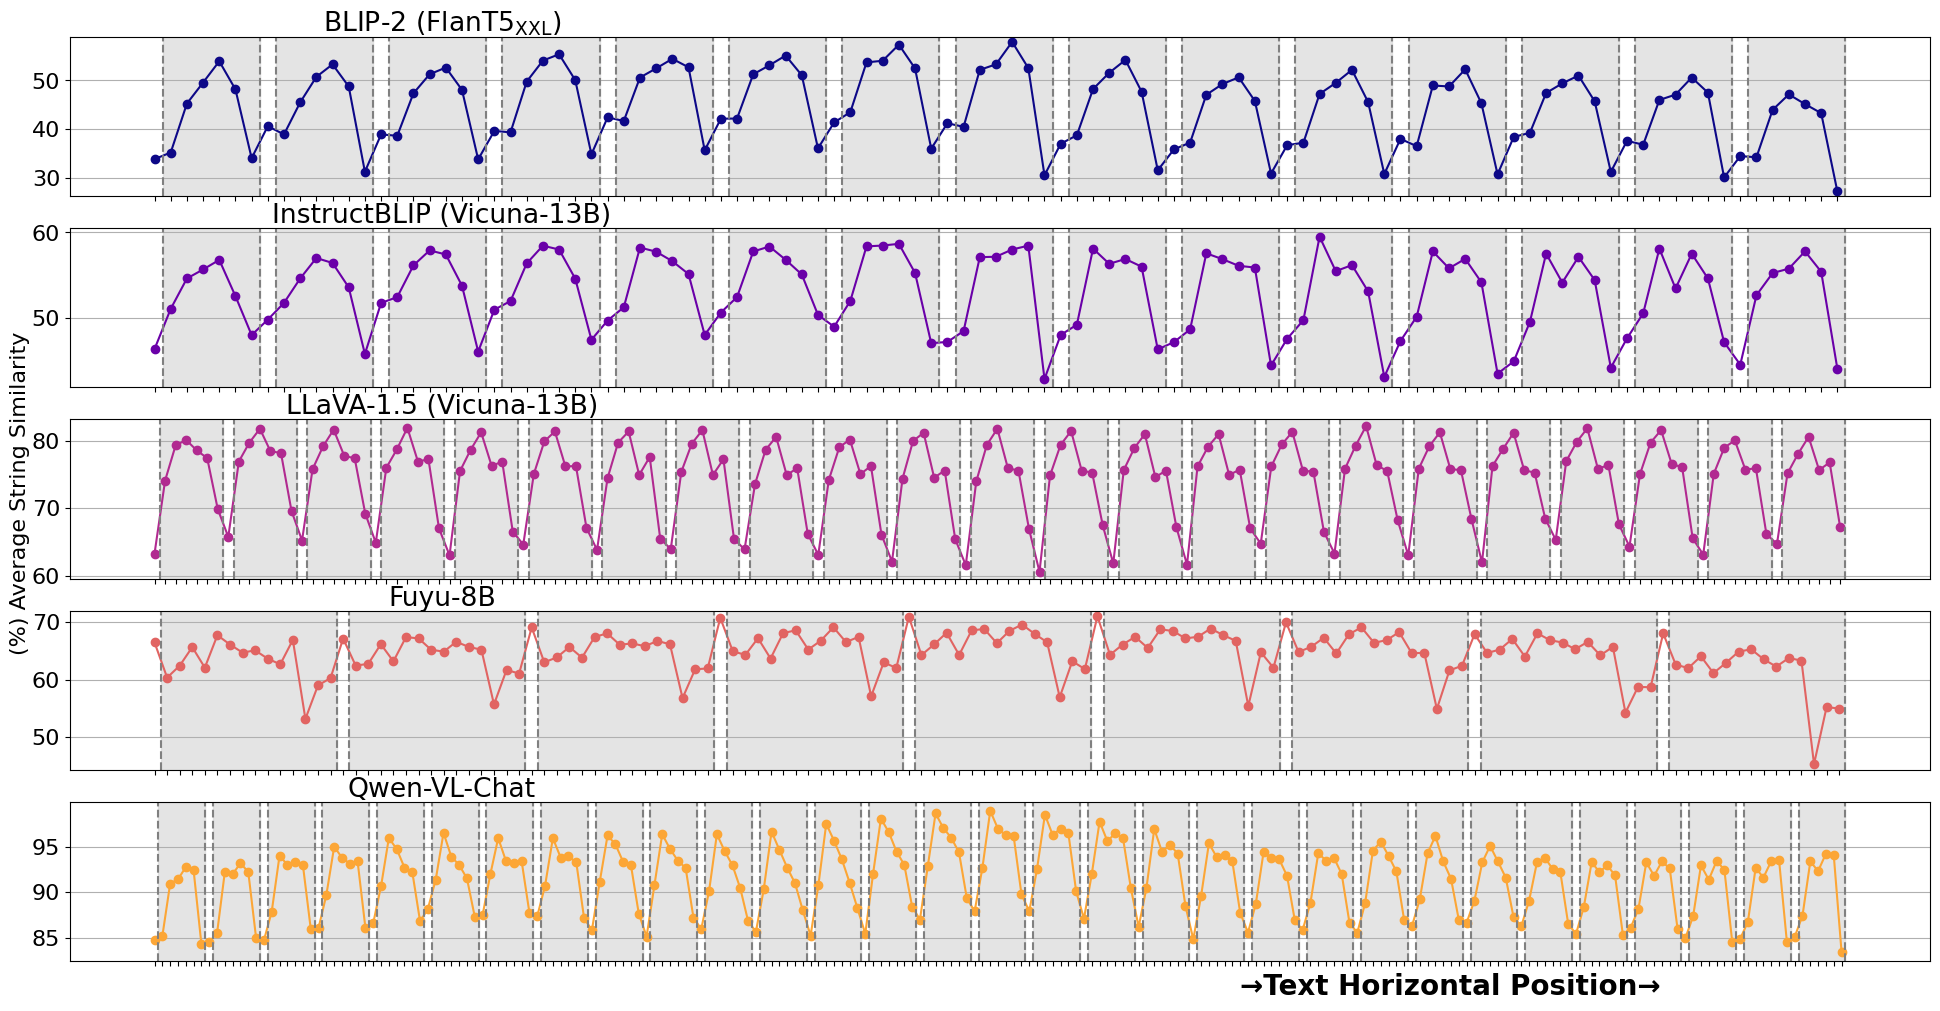

In [4]:
task_name = 'vcut'

task_variations = ['3', '6']

model_to_patch_size = {'blip2-flan-t5-xxl': 14, 
                   'fuyu-8b': 30, 
                   'instructblip-vicuna-13b': 14, 
                   'llava-1.5-13b-hf': 14,
                   'Qwen-VL-Chat': 14}


model_to_patch_num = {'blip2-flan-t5-xxl': 16, 
                   'fuyu-8b': 10, 
                   'instructblip-vicuna-13b': 16, 
                   'llava-1.5-13b-hf': 24,
                   'Qwen-VL-Chat': 32}


result = {}
for model in models:
    if models_to_file[model] == 'fuyu-8b':
        v = '6'
    else:
        v = '3'
    with open(f'{source_dir}/{models_to_file[model]}_{task_name}_{v}.json', 'r') as f:
        data = json.load(f)
    result[model] = get_group_accuracy(data)

fig, ax = plt.subplots(len(models), 1, figsize=(24, 12))

color_map = plt.get_cmap('plasma')

for j, (model, acc) in enumerate(result.items()):
    # left side title
    ax[j].set_title(f'{model}', x=0.2, y=0.98)
    # ax[j].set_xlabel('Text Size')
    # ax[j].set_ylabel('Average String Similarity')
    patch_size = model_to_patch_size[models_to_file[model]]
    patch_num = model_to_patch_num[models_to_file[model]]
    ax[j].yaxis.grid(True)
    ax[j].plot(list(acc.keys()), list(acc.values()), label=model, marker='o', color=color_map(models.index(model)/len(models)))
    ax[j].set_xticklabels([])
    # for k in range(patch_num):
    #     ax[j].axvline(x=patch_size*k//2, color='r', linestyle='--')
    ## add shadow from patch_size*k//2 -1 to patch_size*k//2 + 1
    span = 1.5 if model == 'fuyu-8b' else 0.5
    for k in range(patch_num-1):
        ax[j].axvspan(patch_size*k//2+span, patch_size*k//2-span + patch_size//2, alpha=0.6, color='lightgrey')
        ax[j].axvline(x=patch_size*k//2 - span + patch_size//2, color='grey', linestyle='--')
        ax[j].axvline(x=patch_size*k//2 + span, color='grey', linestyle='--')
    y_min = min(list(acc.values()))
    y_max = max(list(acc.values()))
    ax[j].set_ylim(y_min-1, y_max+1)
# give the whole figure a y label
fig.text(0.1, 0.5, '(%) Average String Similarity', va='center', rotation='vertical')
plt.suptitle('\u2192Text Horizontal Position\u2192', y=0.1, ha='center',fontsize=20, x=0.7, weight='bold')
plt.savefig(f'./plots/compelete_{task_name}.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()